In [1]:
# reference example
from nequip.data import dataset_from_config
from nequip.utils import Config
from nequip.utils.misc import get_default_device_name
from nequip.utils.config import _GLOBAL_ALL_ASKED_FOR_KEYS

from nequip.model import model_from_config




default_config = dict(
    root="./",
    tensorboard=False,
    wandb=False,
    model_builders=[
        "SimpleIrrepsConfig",
        "EnergyModel",
        "PerSpeciesRescale",
        "StressForceOutput",
        "RescaleEnergyEtc",
    ],
    dataset_statistics_stride=1,
    device=get_default_device_name(),
    default_dtype="float64",
    model_dtype="float32",
    allow_tf32=True,
    verbose="INFO",
    model_debug_mode=False,
    equivariance_test=False,
    grad_anomaly_mode=False,
    gpu_oom_offload=False,
    append=False,
    warn_unused=False,
    _jit_bailout_depth=2,  # avoid 20 iters of pain, see https://github.com/pytorch/pytorch/issues/52286
    # Quote from eelison in PyTorch slack:
    # https://pytorch.slack.com/archives/CDZD1FANA/p1644259272007529?thread_ts=1644064449.039479&cid=CDZD1FANA
    # > Right now the default behavior is to specialize twice on static shapes and then on dynamic shapes.
    # > To reduce warmup time you can do something like setFusionStrartegy({{FusionBehavior::DYNAMIC, 3}})
    # > ... Although we would wouldn't really expect to recompile a dynamic shape fusion in a model,
    # > provided broadcasting patterns remain fixed
    # We default to DYNAMIC alone because the number of edges is always dynamic,
    # even if the number of atoms is fixed:
    _jit_fusion_strategy=[("DYNAMIC", 3)],
    # Due to what appear to be ongoing bugs with nvFuser, we default to NNC (fuser1) for now:
    # TODO: still default to NNC on CPU regardless even if change this for GPU
    # TODO: default for ROCm?
    _jit_fuser="fuser1",
)

# All default_config keys are valid / requested
_GLOBAL_ALL_ASKED_FOR_KEYS.update(default_config.keys())

/Users/temporary/anaconda3/envs/torch_mkl/lib/python3.10/site-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 2.0.0 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(


In [2]:
config = Config.from_file('./configs/example.yaml', defaults=default_config)
    

dataset = dataset_from_config(config, prefix="dataset")

validation_dataset = None

dataset[0]

AtomicData(atom_types=[21, 1], cell=[3, 3], edge_cell_shift=[364, 3], edge_index=[2, 364], forces=[21, 3], pbc=[3], pos=[21, 3], total_energy=[1])

In [3]:
# Trainer
from nequip.train.trainer import Trainer

trainer = Trainer(model=None, **Config.as_dict(config))

# what is this
# to update wandb data?
config.update(trainer.params)

# = Train/test split =
trainer.set_dataset(dataset, validation_dataset)

# = Build model =
final_model = model_from_config(
    config=config, initialize=True, dataset=trainer.dataset_train
)

DEBUG:root:* Initialize Output
  ...generate file name results/aspirin/example/log
  ...open log file results/aspirin/example/log
  ...generate file name results/aspirin/example/metrics_epoch.csv
  ...open log file results/aspirin/example/metrics_epoch.csv
  ...generate file name results/aspirin/example/metrics_initialization.csv
  ...open log file results/aspirin/example/metrics_initialization.csv
  ...generate file name results/aspirin/example/metrics_batch_train.csv
  ...open log file results/aspirin/example/metrics_batch_train.csv
  ...generate file name results/aspirin/example/metrics_batch_val.csv
  ...open log file results/aspirin/example/metrics_batch_val.csv
  ...generate file name results/aspirin/example/best_model.pth
  ...generate file name results/aspirin/example/last_model.pth
  ...generate file name results/aspirin/example/trainer.pth
  ...generate file name results/aspirin/example/config.yaml
Torch device: cpu
instantiate Loss
...Loss_param = dict(
...   optional_args =

   optional_args :                                           out_field
   optional_args :                                mlp_output_dimension
...ScalarMLP_param = dict(
...   optional_args = {'mlp_nonlinearity': None, 'mlp_initialization': 'uniform', 'mlp_dropout_p': 0.0, 'mlp_batchnorm': False, 'field': 'edge_features', 'out_field': 'edge_energy', 'mlp_latent_dimensions': [128], 'mlp_output_dimension': 1},
...   positional_args = {'irreps_in': {'pos': 1x1o, 'edge_index': None, 'node_attrs': 3x0e, 'node_features': 3x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e, 'edge_features': 1024x0e}})
instantiate EdgewiseEnergySum
        all_args :                                           num_types
        all_args :                                   avg_num_neighbors
...EdgewiseEnergySum_param = dict(
...   optional_args = {'avg_num_neighbors': 17.211328506469727, 'normalize_edge_energy_sum': True, 'per_edge_species_scale': False, 'num_types': 3},
...   positiona

In [4]:
final_model

GraphModel(
  (model): RescaleOutput(
    (model): GradientOutput(
      (func): SequentialGraphNetwork(
        (one_hot): OneHotAtomEncoding()
        (radial_basis): RadialBasisEdgeEncoding(
          (basis): NormalizedBasis(
            (basis): BesselBasis()
          )
          (cutoff): PolynomialCutoff()
        )
        (spharm): SphericalHarmonicEdgeAttrs(
          (sh): SphericalHarmonics()
        )
        (allegro): Allegro_Module(
          (latents): ModuleList(
            (0-1): 2 x ScalarMLPFunction(
              (_forward): RecursiveScriptModule(original_name=GraphModule)
            )
          )
          (env_embed_mlps): ModuleList(
            (0-1): 2 x ScalarMLPFunction(
              (_forward): RecursiveScriptModule(original_name=GraphModule)
            )
          )
          (tps): ModuleList(
            (0-1): 2 x RecursiveScriptModule(original_name=GraphModule)
          )
          (linears): ModuleList(
            (0-1): 2 x RecursiveScriptMod

In [5]:
from e3nn import o3

l_max = 2

irreps_edge_sh = repr(
            o3.Irreps.spherical_harmonics(
                l_max, p=(-1)
            )
        )

In [6]:
irreps_edge_sh

'1x0e+1x1o+1x2e'

In [14]:
import torch
from torch.nn.functional import one_hot
from nequip.data import AtomicData, AtomicDataDict
from torch.nn.functional import one_hot
from e3nn.nn import FullyConnectedNet
    
from torch import nn
import math


data = AtomicData.to_AtomicDataDict(dataset[0])



# edge length embedding
torch.manual_seed(32)

num_basis = 8
r_max = 5


data_my = {key: torch.clone(data[key]) for key in data}
data_my = AtomicDataDict.with_edge_vectors(data_my, with_lengths=True)

edge_length = data_my['edge_lengths']

bessel_weights = (torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi)
bessel_weights = nn.Parameter(bessel_weights)

edge_length_embedding = 2/r_max*torch.sin(bessel_weights * edge_length.unsqueeze(-1) / r_max)/edge_length.unsqueeze(-1)

# cutoff
factor = 1/r_max
p = 6
    
x = edge_length * factor

cutoff = 1.0
cutoff = cutoff - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
cutoff = cutoff + (p * (p + 2.0) * torch.pow(x, p + 1.0))
cutoff = cutoff - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))
cutoff *= (x < 1.0)

cutoff = cutoff.unsqueeze(-1)

data_my['edge_embedding'] = edge_length_embedding * cutoff

# types embedding
num_classes = 3


edge_ind = data_my['edge_index']

types_embed = one_hot(dataset[0]['atom_types'], num_classes)
types_src = types_embed[edge_ind[0]].squeeze(1)
types_dst = types_embed[edge_ind[1]].squeeze(1)



# latent vector
latent_vector = torch.concatenate([types_src, types_dst, edge_length_embedding], dim = 1)

# MLP
invariant_layers = 2
invariant_neurons = 64
out_neurons = 32

fc = FullyConnectedNet(
    [latent_vector.shape[1]]
    + invariant_layers * [invariant_neurons]
    + [out_neurons],
    torch.nn.functional.silu)

latent_vector_out = fc(latent_vector)


data_my['scalar'] = latent_vector_out

In [15]:
latent_vector.shape

torch.Size([364, 14])

In [16]:
latent_vector_out.shape

torch.Size([364, 32])

In [25]:
from nequip.nn import AtomwiseLinear
from e3nn.o3 import Irreps


#data2_my = {key: torch.clone(data_my[key]) for key in data_my}

linear1 = o3.Linear('32x0e', '32x0e')

weight1 = linear1(latent_vector_out)
weight1.shape

torch.Size([364, 32])

In [34]:
from torch import nn
import math


torch.manual_seed(32)


l_max = 2
irreps_edge_sh = o3.Irreps.spherical_harmonics(2)

data2_my = {key: torch.clone(data2_my[key]) for key in data_my}
data2_my = AtomicDataDict.with_edge_vectors(data2_my, with_lengths=False)


harm_gen = o3.SphericalHarmonics(irreps_edge_sh, True, 'component')

edge_vec = data_my['edge_vectors']

harm_edge = harm_gen(edge_vec)
harm_edge.shape


data2_my['edge_features'] = harm_edge

In [39]:
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from torch_runstats.scatter import scatter

x = data2_my['edge_features']
edge_src = data2_my['edge_index'][1]
edge_dst = data2_my['edge_index'][0]


term_1 = harm_edge
edge_features = torch.einsum('ij,ib->ijb', weight1[edge_src], harm_edge[edge_src])

# TODO: Check if it really right result
edge_features = scatter(edge_features, edge_dst, dim=0, dim_size=len(x))
edge_features.shape

torch.Size([364, 32, 9])

In [111]:
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct

hidden_layer_irrep = o3.Irreps("32x0e + 32x0o + 32x1e + 32x1o + 32x2e + 32x2o")

irreps_in = o3.Irreps("1x0e + 1x1o + 1x2e")
irreps_edge = o3.Irreps("32x0e + 32x1o + 32x2e")


irreps_mid = []
instructions = []

# instructions means stuff for multiplicities
for i, (_, ir_in) in enumerate(irreps_in):
    for j, (mul, ir_edge) in enumerate(irreps_edge):
        for ir_out in ir_in * ir_edge:
            if ir_out in hidden_layer_irrep:
                k = len(irreps_mid)
                irreps_mid.append((mul, ir_out))
                instructions.append((i, j, k, "uvu", True))

# We sort the output irreps of the tensor product so that we can simplify them
# when they are provided to the second o3.Linear
irreps_mid = o3.Irreps(irreps_mid)
irreps_mid, p, _ = irreps_mid.sort()

fctp = FullyConnectedTensorProduct(
            irreps_in,
            irreps_edge,
            hidden_layer_irrep
        )

fctp

/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


FullyConnectedTensorProduct(1x0e+1x1o+1x2e x 32x0e+32x1o+32x2e -> 32x0e+32x0o+32x1e+32x1o+32x2e+32x2o | 15360 paths | 15360 weights)

In [112]:
irrep_in

1x0e+1x1o+1x2e

/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


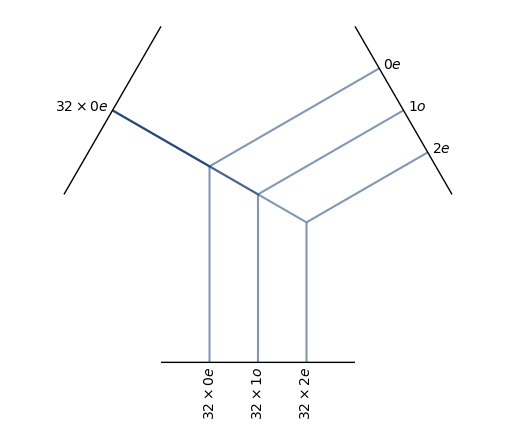

In [132]:
#fctp(irrep_in, o3.Irreps('32x0e'))
irreps_scalar = o3.Irreps('32x0e')


fctp_simple = FullyConnectedTensorProduct(
            irreps_scalar,
            irrep_in, 
            irreps_edge,
            shared_weights = True,
)

fctp_simple.visualize();

In [134]:
fctp_simple

FullyConnectedTensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 3072 paths | 3072 weights)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

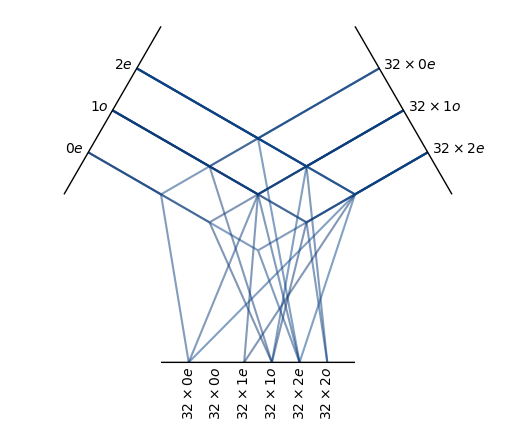

In [135]:
fctp.visualize()

In [136]:
edge_features_simple = fctp_simple(weight1, harm_edge)

In [159]:
fctp_simple.irreps_out

32x0e+32x1o+32x2e

In [137]:
288/9.

32.0

In [138]:
irreps_edge.dim

288

In [139]:
torch.flatten(edge_features.transpose(2, 1), -2)

tensor([[10.9821,  3.1758,  3.1135,  ...,  1.3827, -0.2434,  0.6846],
        [12.6398,  3.0265,  3.4149,  ...,  0.7782, -0.0325,  0.3629],
        [ 9.8607,  3.1041,  2.9073,  ...,  1.5124, -0.0137,  0.7253],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<UnsafeViewBackward0>)

In [140]:
edge_features_simple

tensor([[ 0.3505, -0.2898,  0.1145,  ..., -0.1699,  0.0530, -0.0090],
        [ 0.2857,  0.3281, -0.2155,  ...,  0.0038, -0.0109,  0.0006],
        [ 0.3375, -0.0187,  0.0964,  ...,  0.0609,  0.1595, -0.1194],
        ...,
        [ 0.0991,  0.1712, -0.0548,  ...,  0.4959, -0.5221,  0.1299],
        [ 0.0253,  0.1483, -0.2221,  ..., -0.0326, -0.0756, -0.2059],
        [ 0.0667,  0.2223, -0.0828,  ..., -0.2699, -0.2082,  0.0051]],
       grad_fn=<ReshapeAliasBackward0>)

In [141]:
out = fctp(harm_edge, edge_features_simple)

In [142]:
out.shape

torch.Size([364, 576])

In [70]:
harm_edge.unsqueeze(-1).shape

torch.Size([364, 9, 1])

In [76]:
(edge_features.transpose(2, 1)).shape

torch.Size([364, 9, 32])

In [73]:
edge_features.shape

torch.Size([364, 32, 9])

In [143]:
hidden_layer_irrep

32x0e+32x0o+32x1e+32x1o+32x2e+32x2o

In [180]:
out.shape

torch.Size([364, 576])

In [194]:
from e3nn.nn import Extract

irreps_scalar = []
irreps_features = []
for ir in hidden_layer_irrep:
    if ir.ir[1] == 1 and ir.ir[0] == 0:
        irreps_scalar.append(ir)
    else:
        irreps_features.append(ir)
        
irreps_scalar = o3.Irreps(irreps_scalar)
irreps_features = o3.Irreps(irreps_features)

Extract_new = Extract(hidden_layer_irrep,
        [irreps_scalar, irreps_features],
        instructions=[(0,), (1, 2, 3, 4, 5)])
out2 = Extract_new(out)

Extract_new.irreps_outs

(32x0e, 32x0o+32x1e+32x1o+32x2e+32x2o)

In [198]:
out2[0].shape, out2[1].shape, out.shape

(torch.Size([364, 32]), torch.Size([364, 544]), torch.Size([364, 576]))

In [204]:
in_1 = o3.Irreps('32x0e')
in_2 = o3.Irreps('32x0e')

ir_out2 = in_1 + in_2

scalar_concat = torch.concatenate([latent_vector_out, out2[0]], dim = -1)

linear_scalar = o3.Linear(ir_out2, '32x0e')
linear_features = o3.Linear(hidden_layer_irrep, hidden_layer_irrep)



data2_my['scalar'] = linear_scalar(scalar_concat) + latent_vector_out
data2_my['node_features'] = linear_features(out)

/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [201]:
scalar_concat.shape

torch.Size([364, 64])

In [ ]:
out

In [189]:
Extract_new.irreps_outs[1].slices()

[slice(0, 32, None),
 slice(32, 128, None),
 slice(128, 224, None),
 slice(224, 384, None),
 slice(384, 544, None)]

In [188]:
c = Extract('1e + 0e + 0e', ['0e', '0e'], [(1,), (2,)])
c(torch.tensor([0.0, 0.0, 0.0, 1.0, 2.0]))

(tensor([1.]), tensor([2.]))

In [175]:
len(hidden_layer_irrep), len(irreps_scalar), len(irreps_features)

(6, 1, 5)

In [172]:
tuple(el.dim for el in hidden_layer_irrep)

(32, 32, 96, 96, 160, 160)

In [ ]:
tuple(el.dim for el in irreps_features)

In [163]:
hidden_layer_irrep

32x0e+32x0o+32x1e+32x1o+32x2e+32x2o

In [166]:
len(irreps_features)


5

In [157]:
irreps_features

32x0o+32x1e+32x1o+32x2e+32x2o

In [155]:


irreps_features.dim

544

In [153]:
irreps_features

32x0o+32x1e+32x1o+32x2e+32x2o